In [1]:
import cv2
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../')


from commonfunctions import *
from classifiers import *
from stemRemoval import stemRemoval
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
from skimage import morphology
from skimage.measure import find_contours
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin, binary_opening
from skimage.feature import match_template
import numpy as np
from staffLine import *
from skimage.feature import canny
from skimage.transform import hough_ellipse, resize
from skimage.draw import ellipse_perimeter

from skimage.draw import polygon_perimeter
from skimage.util import crop
import matplotlib.patches as patches
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from skimage import color


In [17]:

img = rgb2gray(io.imread('../dataset/scanned/02.PNG'))
imgOutput = []
if img.dtype != np.uint8:
    noisy_img = (img * 255).astype(np.uint8)
img_median_filtered = hybridMedian(noisy_img)
img_median_filtered = img_median_filtered.astype(np.uint8)
# img_median_filtered = median(noisy_img)
# gaussian filtering
img_gaussian_filtered = gaussian(img_median_filtered, sigma=0.2)
img_gaussian_filtered = (img_gaussian_filtered * 255).astype(np.uint8)

# image rotation
image_rotated = skew_angle_hough_transform(img_gaussian_filtered)
image_rotated = (image_rotated * 255).astype(np.uint8)

# image binarization
binary = adaptiveThresh(image_rotated, t=15, div=8)

# removing stafflines
img_staffLines_removed, staffLines, staffLineSpacing, staffHeight = staffLineRemoval(
    binary, 1)

start_x = get_start_x(binary, len(staffLines), staffHeight)

print(start_x)

binary_clipped = binary[:, start_x:img_staffLines_removed.shape[1]]
img_staffLines_removed_clipped = img_staffLines_removed[:, start_x:img_staffLines_removed.shape[1]]
# split each object in the score to be identified
objects = split_objects(binary_clipped, img_staffLines_removed_clipped, staffLines)

# templates to be used to classify the reltively short symbols with SIFT
templates = read_all_templates()


44


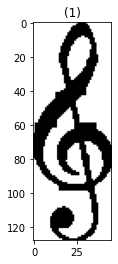

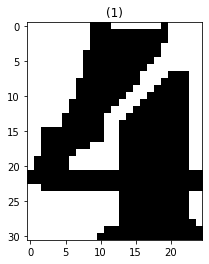

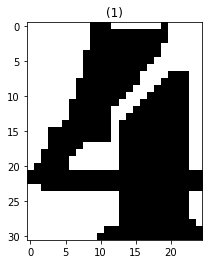

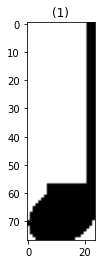

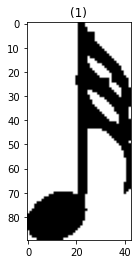

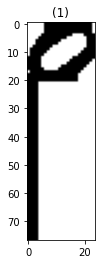

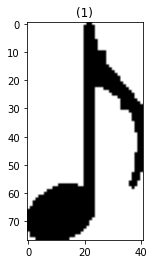

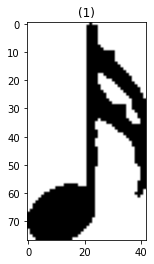

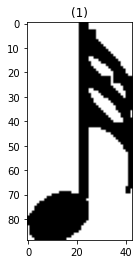

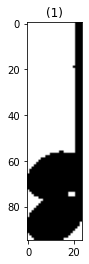

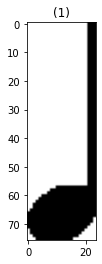

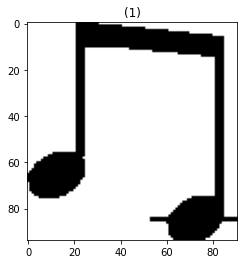

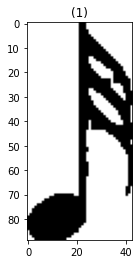

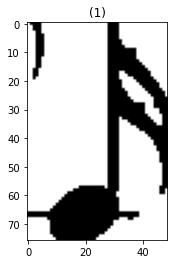

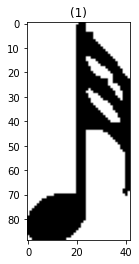

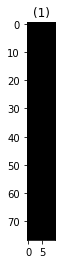

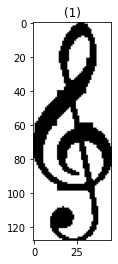

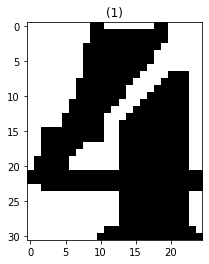

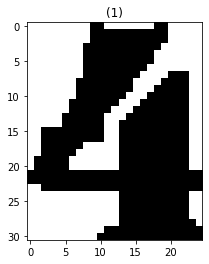

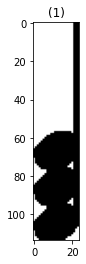

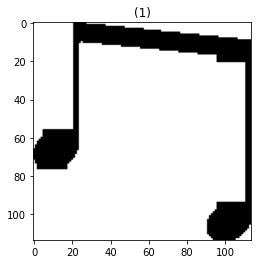

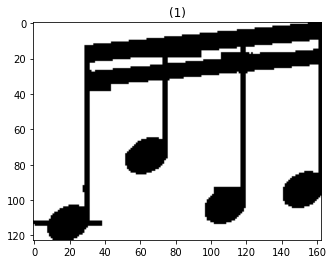

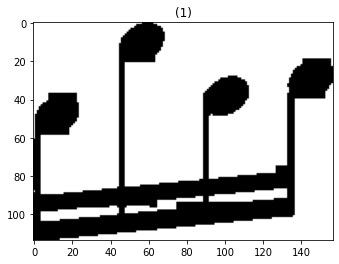

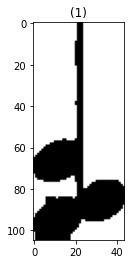

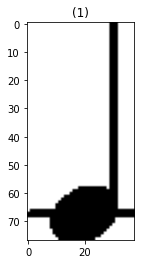

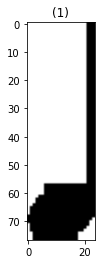

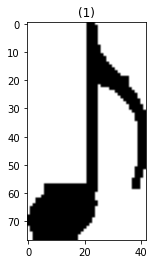

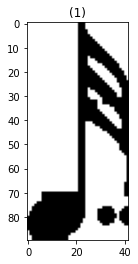

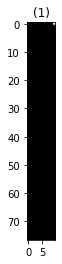

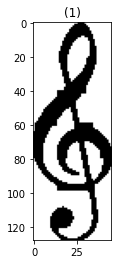

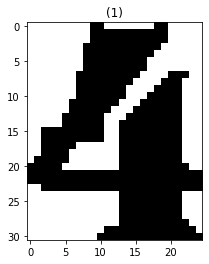

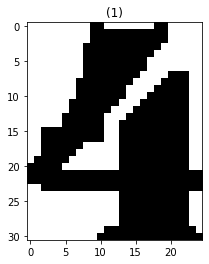

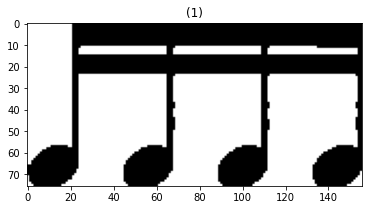

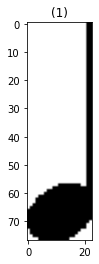

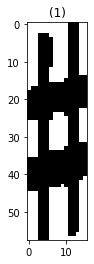

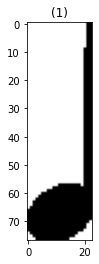

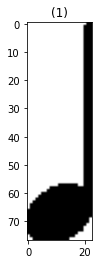

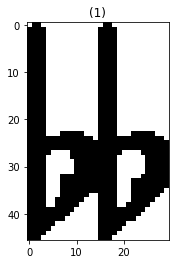

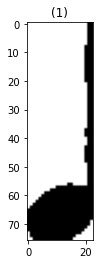

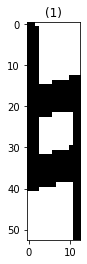

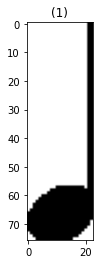

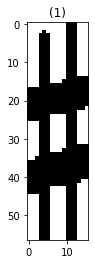

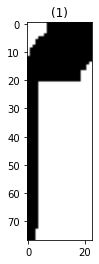

[['\\meter<"4/4">', 'd1/4', 'e1/32', 'e2/2', 'e1/8', 'e1/16', 'e1/32', '{e1/4,g1/4}', 'e1/4', 'e1/8', 'c1/8', 'g1/32', 'c1/16', 'e1/32'], ['\\meter<"4/4">', '{b1/4,e1/4,g1/4}', 'a1/8', 'd1/8', 'c1/16', 'g1/16', 'd1/16', 'e1/16', 'c2/16', 'g2/16', 'd2/16', 'e2/16', '{b1/4,f1/4,g1/4}', 'c1/4', 'a1/4.', 'a1/8', 'a1/32..'], ['\\meter<"4/4">', 'e1/16', 'e1/16', 'e1/16', 'e1/16', 'e1/4', 'e#1/4', 'g1/4', 'g&&1/4', 'g1/4', 'e#2/4']]


In [18]:
# if the score had multiple groups we divide them into blocks that have 5 stafflines
sameBlock = objects[0][2]
# each block has different pitches coordinates
pitches, pitches_coord = getPitchesCoordinates(
    staffLineSpacing, staffLines, sameBlock)
imgOutput.append([])
accidentals = ""
number = 0
two = False
for object, top, blockNumber, dots in objects:
    show_images([object])
    # if the we entered a new block recalculte the pitches coordinates
    if sameBlock != blockNumber:
        imgOutput.append([])
        sameBlock = blockNumber
        pitches, pitches_coord = getPitchesCoordinates(
            staffLineSpacing, staffLines, blockNumber)

    # classify the relatively short symbols using SIFT
    if len(object) < 3.5*staffLineSpacing:
        objectLabel, objectType = classify_accidentals(
            (object, top, blockNumber), templates, staffLineSpacing)
        if objectType == "accidental":
            accidentals += objectLabel
        if objectLabel == 'full_note':
            objectLabel = pitches[find_nearest(
                pitches_coord, top + len(object)/2)] + '/1'
            objectLabel = objectLabel + '.' * dots
        if objectType == "number":
            number = number + 1
            if objectLabel == "2":
                two = True
        if number == 2:
            if two == True:
                imgOutput[-1].append('\meter<"4/2">')
            else:
                imgOutput[-1].append('\meter<"4/4">')
            two = False
            number = 0
        continue
    objectWithouStem, stems = stemRemoval(object, staffLineSpacing)
    if len(stems) == 0:
        continue
    elif len(stems) == 1:
        note = ChordsClassifier(
            objectWithouStem, top, staffLineSpacing, pitches, pitches_coord)
        if note != '':
            imgOutput[-1].append(note)
            continue
        note = classifierA(objectWithouStem, stems, staffLineSpacing,
                            staffHeight, top, pitches, pitches_coord, dots, accidentals)
        if note != '':
            imgOutput[-1].append(note)
            accidentals = ""
    else:
        if chordOrBeamCheck(objectWithouStem) == 'chord':
            note = ChordsClassifier(
                object, top, staffLineSpacing, pitches, pitches_coord)
            if note != '':
                imgOutput[-1].append(note)
        else:
            beamClassifier(object, objectWithouStem, staffLineSpacing,
                            staffHeight, top, pitches, pitches_coord)
            notes = beamClassifier(object, objectWithouStem, staffLineSpacing,
                                    staffHeight, top, pitches, pitches_coord)
            imgOutput[-1].extend(notes)
print(imgOutput)

In [14]:
for object in objects:
    staffLineSpacing = 20
    testNoStem, stems = stemRemoval(object, 20)
    print('stems (positions, widths) found: ', stems)
    another = np.copy(object)
    orig = np.copy(object)
    object = 255 - object
    height, width = object.shape
    horiz_proj = (np.sum(object/255, axis=1)).astype('uint32')
    vert_proj = (np.sum(object/255, axis=0)).astype('uint32')


    # visualize the horizontal projection
    m = np.max(horiz_proj, initial=0)
    if m == 0:
        m = 1
    result = np.zeros((height,width))
    # Draw a line for each row
    for row in range(height):
        cv2.line(result, (0,row), (int(horiz_proj[row]*width/m),row), 255, 1)

    # visualize the vertical projection
    m = np.max(vert_proj, initial=0)
    if m == 0:
        m = 1
    result2 = np.zeros((height, width))
    
    # thresholding to remove non stems from the image in the vertical projection for visualisation
    max_vertical = 0.8 * m
    vert_proj = np.where(vert_proj <= max_vertical, 0, vert_proj)
    mask = np.where(vert_proj!=0, 1, 0)
    # Draw a line for each row
    for col in range(width):
        cv2.line(result2, (col,0), (col,int(vert_proj[col]*height/m)), 255, 1)


    # Perform the distance transform algorithm
    # dist = cv2.distanceTransform(object, cv2.DIST_L1, 5)
    # max = dist.max()
    # # dist = np.where(dist < max, 0, 255)

    # # dist=cv2.distanceTransform(255-object,cv2.DIST_L2,3)
    # cv2.normalize(dist,dist,0,1.0,cv2.NORM_MINMAX)
    # _,mv,_,mp = cv2.minMaxLoc(dist)
    # #print(mv*2, mp) # (half)width*2, pos
    # draw = cv2.cvtColor(object, cv2.COLOR_GRAY2BGR)
    # cv2.line(draw, (0,mp[1]), (object.shape[1],mp[1]), (0,0,200), 3, -1)
    
    stems = np.nonzero(mask)[0]

    mask = np.array([mask,]*height) * 255
    # another method to remove the stems
    if height != 0:
        another = another+mask
        se = np.zeros((3,3))
        se[se.shape[0]//2+1, :] = 1 
        # to remove the excess due to the stem removals
        another = binary_closing(another, se)

    show_images([orig, another, result, result2, testNoStem], ['original', 'stem removal approach2', 'horizontal projection', 'vertical projection of stems and larger objects', 'stem removal approach1'])

ValueError: not enough values to unpack (expected 2, got 1)

In [6]:
gray = thresh
edges = cv2.Canny(gray,50,150,apertureSize = 3)
cv2.imwrite('edges-50-150.jpg',edges)
minLineLength=100
lines = cv2.HoughLinesP(image=edges,rho=1,theta=np.pi/180, threshold=100,lines=np.array([]), minLineLength=minLineLength,maxLineGap=80)

a,b,c = lines.shape
for i in range(a):
    x = lines[i][0][0] - lines [i][0][2]
    y = lines[i][0][1] - lines [i][0][3]
    if x!= 0:
        if abs(y/x) <1:
            cv2.line(gray, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (255, 255, 255), 1, cv2.LINE_AA)

se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE , (4,4))
gray = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, se)
gray = np.where(gray % 255, 0, gray)
gray =1- morphology.binary_dilation(255 - gray, np.ones((11,3)))
#gray = 1 - skeletonize(gray)

# height, width = gray.shape
# for i in range(height):
#     for j in range(width):
#         if (gray[i, j] != 0 and gray[i,j] != 255):
#             print(gray[i,j]) 

io.imsave('houghlines.png', gray.astype('float64'))
show_images([gray])


output = gray
# Find contours at a constant value of 0.8
contours = find_contours(output, 0.8)

fig, ax = plt.subplots()
ax.imshow(output, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

NameError: name 'thresh' is not defined

# testing for image prespective view

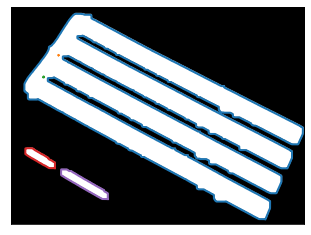

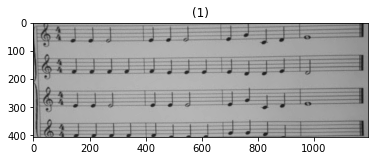

In [5]:

from skimage import feature, filters
from skimage import transform as tf
from skimage import data
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin

def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect

def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped


realImg = io.imread("./dataset/multiple_skewed_scanned.png", as_gray=True)
img = feature.canny(realImg)
img_closed = binary_dilation(img, np.ones((25, 25)))
# Find contours at a constant value of 0.8
contours = find_contours(img_closed, 0.8)
fig, ax = plt.subplots()
ax.imshow(img_closed, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

bounding_boxes = []
p1 = -1
p2 = -1
p3 = -1
p4 = -1
diag_area = -1
for contour in contours:
    sorted_x = contour[np.argsort(contour[:, 1])]
    sorted_y = contour[np.argsort(contour[:, 0])]
    xmin = (min(contour[:, 1]))
    xmax = (max(contour[:, 1]))
    ymin = (min(contour[:, 0]))
    ymax = (max(contour[:, 0]))
    area = (xmax - xmin) * (ymax - ymin)
    if area > diag_area:
        diag_area = area
        diagx_min = np.int32(round(xmin))
        p1 = np.int32(sorted_x[0, :])
        p2 = np.int32(sorted_x[-1, :])
        p3 = np.int32(sorted_y[0, :])
        p4 = np.int32(sorted_y[-1, :])

# ax[0].imshow(img)
# ax[0].set_title('Input image')


# ax[1].imshow(img)
# origin = np.array((0, img.shape[1]))
# print(origin)
# hspace, angles, dists = hough_line_peaks(h, theta, d)

# min_y0 = 100000
# max_y0 = -1
# min_y1 = 100000
# max_y1 = -1

# for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
#     y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
#     min_y0 = min(y0, min_y0)
#     max_y0 = max(y0, max_y0)
#     min_y1 = min(y1, min_y1)
#     max_y1 = max(y1, max_y1)
#     print((y0, y1))
#     ax[1].plot(origin, (y0, y1), '-r')
# shift = 100
# ax[1].plot(origin, (min_y0, min_y1), '+r')
# ax[1].plot(origin, (max_y0, max_y1), '+r')

# slope = (min_y1 - min_y0) / origin[1] - origin[0]

# intercept0 = min_y0 - slope * origin[0]
# intercept1 = min_y0 - slope * origin[1]


# # min_y0 -= shift
# # min_y1 -= shift
# # max_y0 += shift
# # max_y1 += shift
# plt.show()





# src = np.array([[0, 0], [0, 300], [600, 300], [600, 0]])
# # dst = np.array([[origin[0], min_y0 -shift], [origin[0], max_y0 + shift], [origin[1], max_y1 + shift], [origin[1], min_y1 - shift]])
# dst = np.array([[origin[0],intercept0], [origin[0], intercept0], [origin[1], max_y1 + shift], [origin[1], min_y1 - shift]])
# tform3 = tf.ProjectiveTransform()
# tform3.estimate(src, dst)
# warped = tf.warp(realImg, tform3, output_shape=(300, 600))

# fig, ax = plt.subplots(nrows=2, figsize=(8, 3))

# ax[0].imshow(realImg)
# ax[0].plot(dst[:, 0], dst[:, 1], '.r')
# ax[1].imshow(warped)

# for a in ax:
#     a.axis('off')

# plt.tight_layout()

pts = np.array([np.flip(p1), np.flip(p2), np.flip(p3), np.flip(p4)], dtype = "float32")
wraped = four_point_transform(realImg, pts)

show_images([wraped])


In [ ]:
def getHoughLines(imgFile):
    img = cv2.imread(imgFile)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray,50,150,apertureSize = 3)

    lines = cv2.HoughLines(edges, 1, np.pi/180, 200)
    for line in lines:
        for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))

            cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

    cv2.imwrite("gray.png", img)

def removeLinesFromSheet(imgFile):

    img = cv2.imread(imgFile)

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    adaptiveThreshHoldImage = adaptiveThresh(~gray, 15, 8)

    cv2.imwrite("adaptive.png", adaptiveThreshHoldImage)

    horizontal = adaptiveThreshHoldImage.copy()
    vertical = adaptiveThreshHoldImage.copy()

    (rows, cols) = adaptiveThreshHoldImage.shape

    horizontalSize = cols//30
    verticalSize = rows//30

    horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT,(horizontalSize, 1))

    horizontal = cv2.erode(horizontal, horizontalStructure, iterations = 1)
    horizontal = cv2.dilate(horizontal, horizontalStructure, iterations = 1)

    cv2.imwrite("horizontal.png", horizontal)

    verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT,(1, 3))

    vertical = cv2.erode(vertical, verticalStructure, iterations = 1)
    vertical = cv2.dilate(vertical, verticalStructure, iterations = 1)

    vertical = cv2.bitwise_not(vertical)

    cv2.imwrite("verical.png", vertical)

    smoothedThreshHoldImg = cv2.adaptiveThreshold(vertical, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, -2)

    cv2.imwrite("edges.png", smoothedThreshHoldImg)
    cv2.imwrite("bitwise.png", horizontal)
    output = adaptiveThreshHoldImage - horizontal
    cv2.imwrite("output.png", output)
    return output

def read_staff_lines(img):
	edges = cv2.Canny(img,150,700)

	lines = cv2.HoughLines(edges,1,np.pi/180,200)
	staff_lines = []
	for rho,theta in lines[0]:
	    a = np.cos(theta)
	    b = np.sin(theta)
	    x0 = a*rho
	    y0 = b*rho
	    x1 = int(x0 + 1000*(-b))
	    y1 = int(y0 + 1000*(a))
	    x2 = int(x0 - 1000*(-b))
	    y2 = int(y0 - 1000*(a))

	    th = 10 #pixels
	    too_close = False

	    # only appends lines if they're a reasonable distance
	    # from other lines
	    # would be better if used averaging between close lines instead of
	    # just taking the first one we see and tossing the other
	    for y in staff_lines:
	      	if abs(y - y1) <= th:
	    	    too_close = True
	    if not too_close:
	    	staff_lines.append((y1))

	return staff_lines
path = "./dataset/multiple_lines_scanned.png"
getHoughLines(path)
thresholded = removeLinesFromSheet(path)
output = thresholded
se = np.ones((3,3))
# se[1,: ] = 1
# se[:, 1] = 1

#[[0, 1, 0],[1, 1, 1],[0, 1, 0]]
se = np.ones((4, 2))
output = morphology.binary_erosion(output, se)
se = np.ones((10,3))
output = morphology.binary_dilation(output, se)





# Find contours at a constant value of 0.8
contours = find_contours(output, 0.8)

fig, ax = plt.subplots()
ax.imshow(output, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()




io.imsave("output.png", 1-output.astype('float64'))
show_images([1-output])
#output = cv2.dilate(output, horizontalStructure, iterations = 1)


In [ ]:
 sift = cv2.xfeatures2d.SIFT_create()
        kp1, des1 = sift.detectAndCompute(tmp, None)
        kp2, des2 = sift.detectAndCompute(obj, None)
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des1, des2, k=2)
        good = []
        for m, n in matches:
            if m.distance < accuracy*n.distance:
                good.append([m])
        p = len(good)/(min(len(kp1), len(kp2)))
        #print("percentage = {}".format(p*100))
        return p*100